[![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/aws/sagemaker/sagemaker-pinecone-rag.ipynb)

# Module 02 - Query data and generate a simple RAG response


This module contains notebook code to:
* Query the data from Pinecone Index
* Perform semantic search
* Generate RAG response using Amazon Bedrock 


*******************************************************************************************************************

### Install required libraries

In [ ]:
%pip install --quiet --upgrade \
    pinecone \
    boto3 \
    botocore

To begin, we will initialize Amazon Bedrock and Pinecone that we'll need to use throughout the walkthrough.

In [ ]:
# Standard library imports
import getpass
import json

# Pinecone library
from pinecone import Pinecone

# AWS Library imports
import boto3
from botocore.config import Config

### Initialize Pinecone

In [ ]:
PINECONE_API_KEY = getpass.getpass("Enter Pinecone API Key")
pc = Pinecone(api_key=PINECONE_API_KEY, source_tag="pinecone:agentic_ai_with_pinecone_and_aws:notebooks:2_data_query_pipeline")

#### Configure Pinecone variables

In [ ]:
index_name = 'agentic-ai-with-pinecone-and-aws'
namespace = '__default__' # Namespaces are used to organize data in Pinecone, like for multi-tenant applications. We'll use the default namespace for this workshop.

### Setup AWS environment

If you're running this workshop as part of a Pinecone-hosted event, the Jupyter environment only has access to `BEDROCK_ACCESS_KEY` and `BEDROCK_SECRET_KEY`, so we need to assign these to the default keys that the Bedrock client will read from the environment.

If you are not running this as part of a Pinecone-hosted event and running locally or in a Colab environment, you'll need to set `AWS_ACCESS_KEY_ID` and `AWS_SECRET_ACCESS_KEY` in your respective environment first. Then you can skip to the "Initialize Bedrock client" section below.

In [ ]:
import os

# Set correct env vars because Instruqt workshop uses different keys
#
# Comment these two lines out if you are not running in
# this in a Pinecone-hosted workshop event
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('BEDROCK_ACCESS_KEY')
os.environ['AWS_SECRET_ACCESS_KEY'] = os.getenv('BEDROCK_SECRET_KEY')

### Initialize Bedrock client

Now we can initialize the Bedrock client:

In [ ]:
config = Config(connect_timeout=5, read_timeout=60, retries={"total_max_attempts": 20, "mode": "adaptive"})
region = 'us-east-1'

bedrock = boto3.client(
                service_name='bedrock-runtime',
                region_name=region,
                endpoint_url=f'https://bedrock-runtime.{region}.amazonaws.com',
                                    config=config)

embedding_model_id = "amazon.titan-embed-text-v2:0"
generation_model_id = "anthropic.claude-3-haiku-20240307-v1:0"

### Initialize Pinecone Index and describe stats

In [ ]:
index = pc.Index(index_name)
print(index.describe_index_stats())

### Query the data

Now we're ready begin querying our LLM with a **R**etrieval **A**ugmented **G**eneration (RAG) pipeline. Let's see how this will work step-by-step first.

- Step 1. Generate vector embedding of the text query using Amazon Bedrock
- Step 2. Perform semantic search, retrieving the records that are most similar in meaning and context to the query
- Step 3. Rerank the results to further refine them
- Step 4. Results are combined with the original user query to create a prompt for the LLM
- Step 5. This curated context is then used to generate output, using the context to drive a more accurate and relevant response

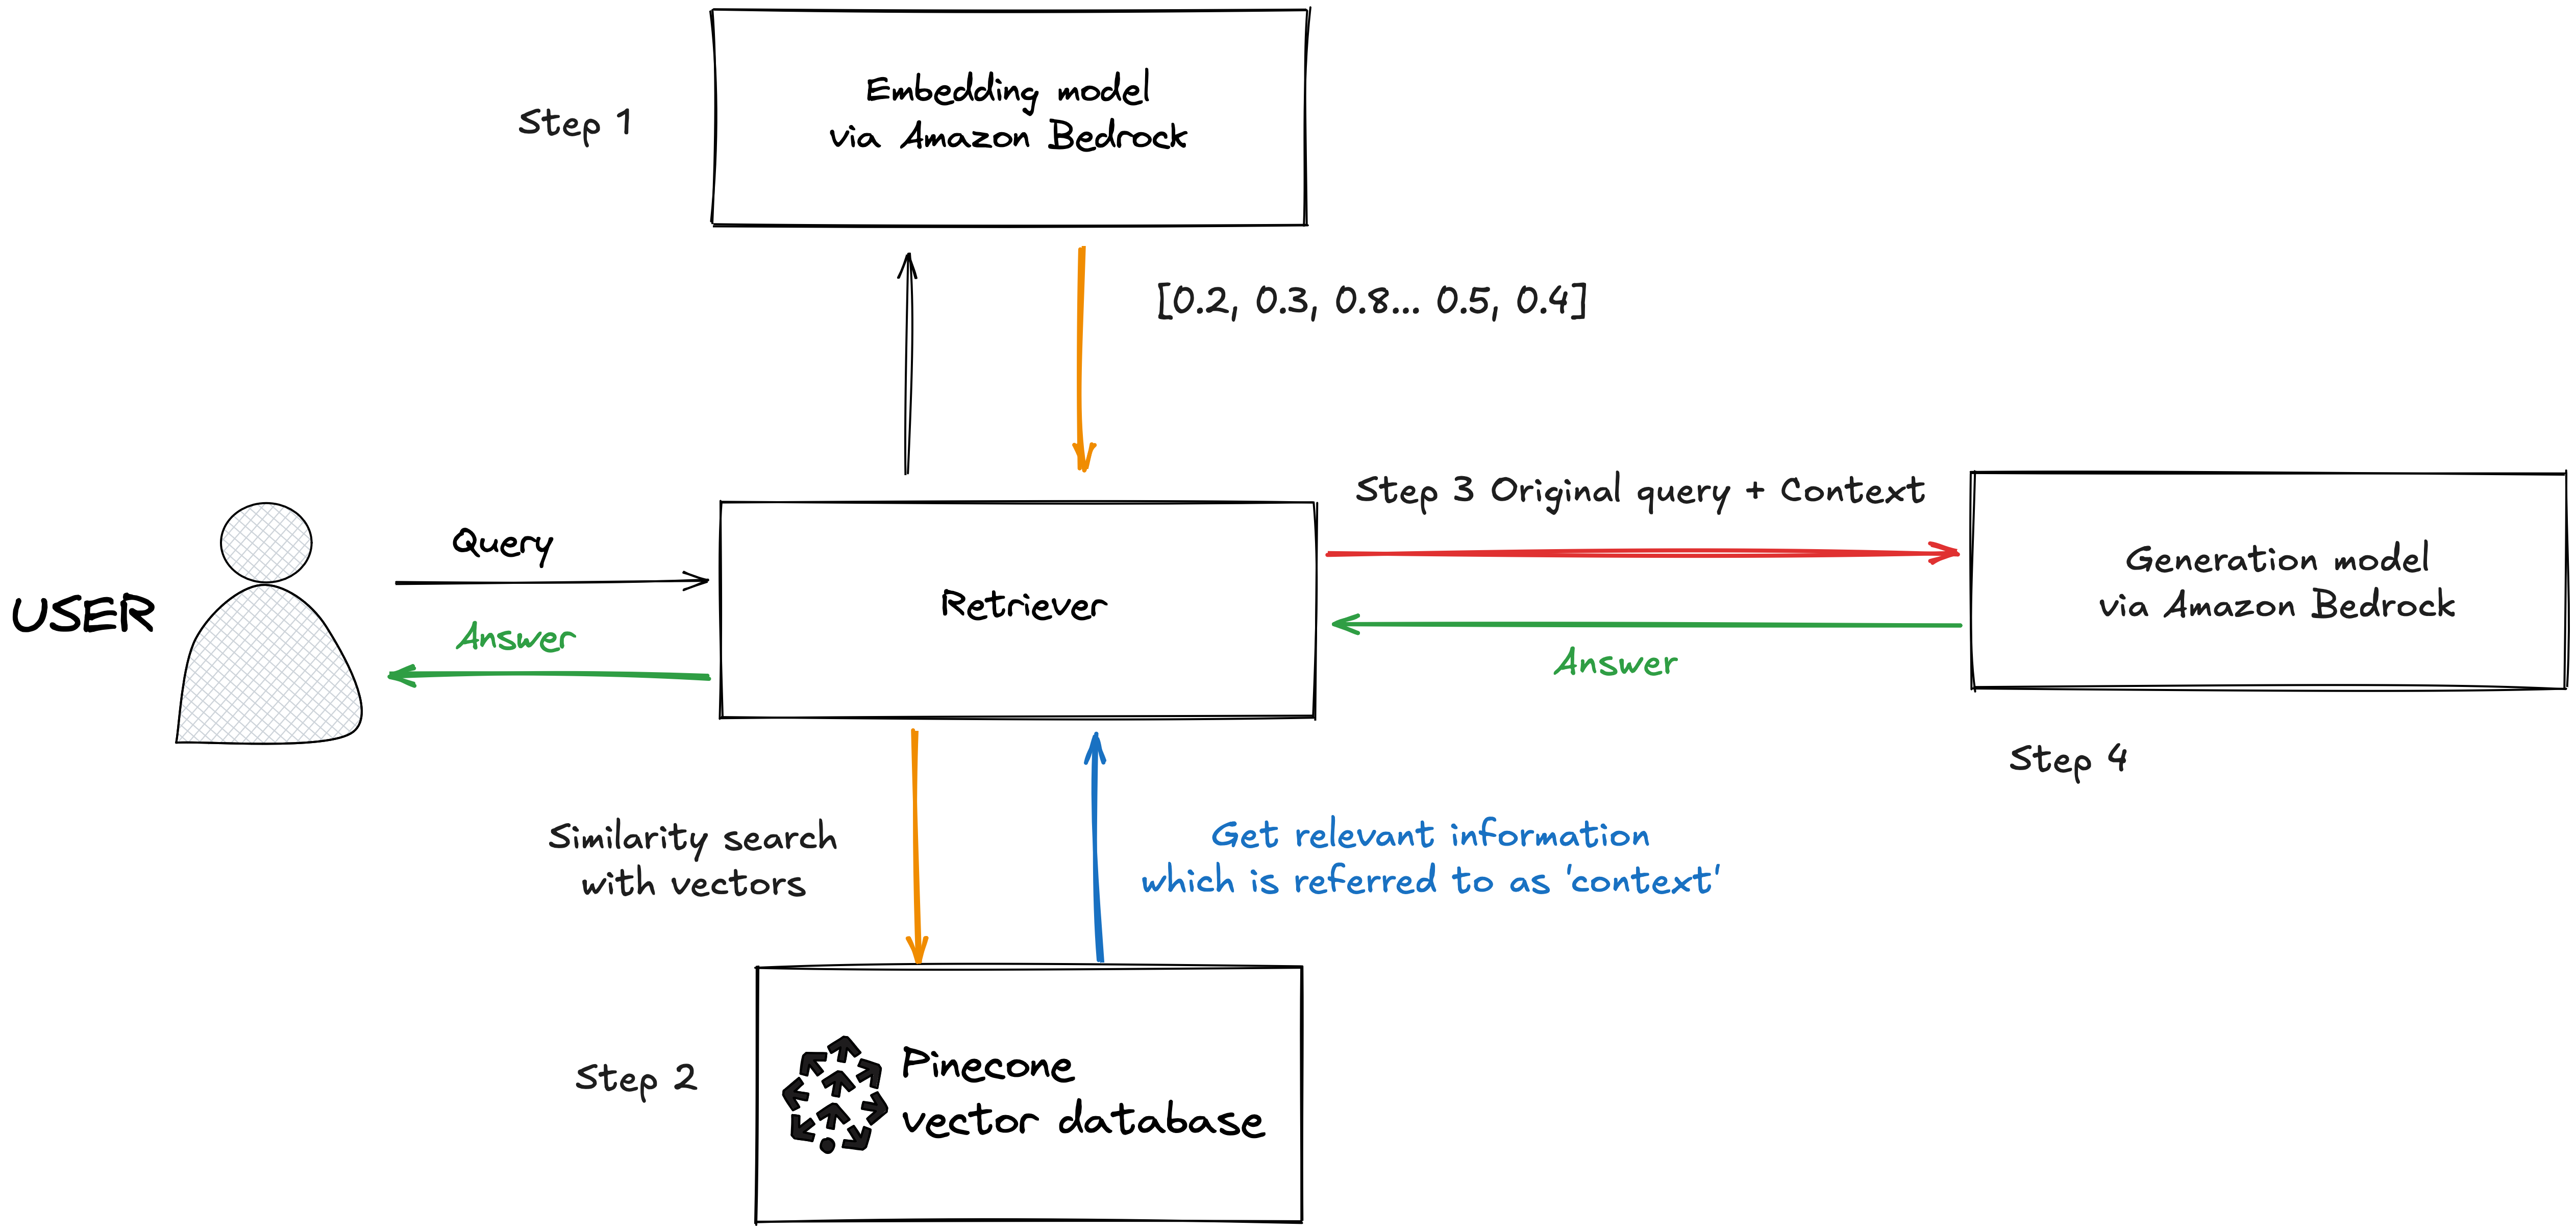

#### Step 1: Generate vector embedding of the query

First, we define a function to create our _query embedding_ so we can query the Pinecone index.

In [ ]:
def embed_query(query: str) -> float:
    """
    Generate text embedding by using Amazon Bedrock.
    Args:
        query: string of text to embed.
    Returns:
        dict: embedding in float type.
    """

    body = json.dumps({"inputText": query})

    response = bedrock.invoke_model(
        body=body,
        modelId=embedding_model_id,
    )

    response_body = json.loads(response.get('body').read())
    embedding = response_body.get('embedding')

    return embedding

#### Step 2: Perform semantic search

Next, we define a function to perform semantic search against the Pinecone index. This function will use the query embedding to retrieve the records that are most similar in meaning and context to the query.

In [ ]:
def semantic_search(query: list) -> list:
    """
    Query the Pinecone index with an optional rerank.

    Args:
        query (str): The query string.

    Returns:
        list: A list of hit records from the index.
    """
    query_embedding = embed_query(query)

    search_results = index.query(
        namespace=namespace,
        vector=query_embedding,
        fields=["chunk_text"],
        top_k=20
    )

    document_ids = []
    
    for result in search_results['matches']:
        document_ids.append(result['id'])

    fetch_results = index.fetch(ids=document_ids, namespace=namespace)

    documents_retrieved = []

    for document_id in document_ids:
        text = fetch_results.vectors[document_id]['metadata']['chunk_text']
        documents_retrieved.append({"id": document_id, "text": text})

    return documents_retrieved

Now, we can query the database with the text query.

In [ ]:
query = "Changes in Compaq's product offerings and their impacts on sales"

documents_retrieved = semantic_search(query)

And let's inspect the first three records retrieved:

In [ ]:
documents_retrieved[:3]

#### Step 3: Rerank the results

We could further refine these 20 results by reranking them. To rerank the results, we send the original query and the results to a reranking model. The reranking model scores the results based on their semantic relevance to the query and returns a new, more accurate ranking. This approach is one of the simplest methods for improving quality in retrieval-augmented generation (RAG) pipelines.

In [ ]:
def rerank_results(query: str, docs: list):
    reranked_results = pc.inference.rerank(
        model="bge-reranker-v2-m3",
        query=query,
        documents=docs,
        top_n=3,
        rank_fields=["text"],
        return_documents=True,
        parameters={
            "truncate": "END"
        }
    )

    return reranked_results

In [ ]:
reranked_documents = rerank_results(query, documents_retrieved)

In [ ]:
reranked_documents.data

#### Step 4: Augmentation

Now, we'll combine the results with the original user query to create a prompt for the LLM. Let's format them into a search template using techniques Claude has been trained with and add the formatted descriptions to a prompt. We'll use this prompt to send the search results as context to the generation step.

In [ ]:
# Formatting search results
def format_results(extracted: list[str]) -> str:
        result = "\n".join(
            [
                f'<item index="{i+1}">\n<page_content>\n{r["document"]["text"]}\n</page_content>\n</item>'
                for i, r in enumerate(extracted.data)
            ]
        )
    
        return f"\n<search_results>\n{result}\n</search_results>"

def augment_prompt(results_list, question):
    return f"""\n\nHuman: {format_results(results_list)} Using the search results provided within the <search_results></search_results> tags, please answer the following question <question>{question}</question>. Do not reference the search results in your answer.\n\nAssistant:"""

augmented_prompt = augment_prompt(reranked_documents, query)

print(augmented_prompt)

#### Step 5: Generation with Claude

Finally, let's ask the original user's question and get our answer from Claude.

In [ ]:
def generate_answer(prompt: str) -> str:
    body = json.dumps({
        "anthropic_version": "bedrock-2023-05-31",
        "messages": [
            {
                "role": "user",
                "content": augmented_prompt
            }
        ],
        "max_tokens": 1000,
        "temperature": 0.1
    })

    response = bedrock.invoke_model(
        body=body,
        modelId=generation_model_id,
    )

    response_body = json.loads(response.get('body').read())

    # Extract the response text from Claude's response format
    response_text = response_body['content'][0]['text']
    
    return response_text

print(generate_answer(augmented_prompt))

### Putting it all together

Let's put it all together! Below, we search, rerank, augment the prompt with the results, and generate an answer to complete a simple RAG pipeline.

In [ ]:
query = "Changes in Compaq's product offerings and their impacts on sales"

# Search
documents_retrieved = semantic_search(query)

# Rerank
reranked_documents = rerank_results(query, documents_retrieved)

# Augment
augmented_prompt = augment_prompt(reranked_documents, query)

# Generate
answer = generate_answer(augmented_prompt)

print(answer)